# CST 383: Intro to Data Science  
Project 2: Predicting Kickstarter Goal Completion  
**Authors:** Brianna Magallon, Tyler Pruitt, Rafael L.S. Reis

# Introduction

In this project, we use the Kickstarter Projects dataset to build a model that predicts whether a crowdfunding campaign will succeed or fail based on information available at launch. Each entry includes metadata such as goal amount, number of backers, campaign duration, and category.

We treat this as a **binary classification problem**, where the outcomes are `'successful'` or `'failed'`. We merge `'canceled'` campaigns into the `'failed'` category, based on the observation that they typically don't meet funding goals.

**Dataset Source:**  
[Kickstarter Projects (Kaggle)](https://www.kaggle.com/datasets/kemical/kickstarter-projects)

In [1]:
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [2]:
sns.set_theme(style='whitegrid', context='notebook')
plt.rcParams['figure.figsize'] = 5,3

# Data Exploration

In [3]:
df = pd.read_csv("ks-projects-201612.csv", encoding="cp1252", low_memory=False)

In [4]:
df.columns = df.columns.str.strip()
df.sample(5)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
145708,1865777838,Design & Publish MineCraft style Mobile Games,Mobile Games,Games,GBP,2015-04-21 23:23:17,1500,2015-03-22 22:23:17,28,failed,4,GB,41.869597,NaN,NaN,NaN,NaN
201125,264694355,Implementing an AWESOME Dance/Art/Fitness Niag...,Dance,Dance,CAD,2014-04-30 20:23:17,2000,2014-04-15 20:23:17,0,failed,0,CA,0,NaN,NaN,NaN,NaN
106125,1630168903,"50 Preposterous Paintings by October, 2012",Painting,Art,USD,2012-05-17 03:37:51,5000,2012-04-17 03:37:51,0,failed,0,US,0,NaN,NaN,NaN,NaN
59547,1353782287,Nepal Culture Conservation,Documentary,Film & Video,USD,2013-04-19 02:43:37,700,2013-03-20 01:43:37,2,failed,2,US,2,NaN,NaN,NaN,NaN
46207,1274739942,One Dollar. The Road to Royalty Project.,Hip-Hop,Music,USD,2014-08-26 22:23:52,500,2014-07-27 22:23:52,1,failed,1,US,1,NaN,NaN,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323750 entries, 0 to 323749
Data columns (total 17 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ID             323750 non-null  int64  
 1   name           323746 non-null  object 
 2   category       323745 non-null  object 
 3   main_category  323750 non-null  object 
 4   currency       323750 non-null  object 
 5   deadline       323750 non-null  object 
 6   goal           323750 non-null  object 
 7   launched       323750 non-null  object 
 8   pledged        323750 non-null  object 
 9   state          323750 non-null  object 
 10  backers        323750 non-null  object 
 11  country        323750 non-null  object 
 12  usd pledged    319960 non-null  object 
 13  Unnamed: 13    625 non-null     object 
 14  Unnamed: 14    12 non-null      object 
 15  Unnamed: 15    4 non-null       object 
 16  Unnamed: 16    1 non-null       float64
dtypes: float64(1), int64(1), obje

In [6]:
df['state'].value_counts()

state
failed        168221
successful    113081
canceled       32354
live            4428
undefined       3555
               ...  
2312               1
320                1
477                1
1404               1
2634               1
Name: count, Length: 410, dtype: int64

In [7]:
df[df['state'] == "canceled"].head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
3,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29 01:00:00,19500,2015-07-04 08:35:03,1283,canceled,14,US,1283,NaN,NaN,NaN,NaN
7,1000034518,SPIN - Premium Retractable In-Ear Headphones w...,Product Design,Design,USD,2014-05-29 18:14:43,125000,2014-04-24 18:14:43,8233,canceled,58,US,8233,NaN,NaN,NaN,NaN
8,100004195,STUDIO IN THE SKY - A Documentary Feature Film...,Documentary,Film & Video,USD,2014-08-10 21:55:48,65000,2014-07-11 21:55:48,6240.57,canceled,43,US,6240.57,NaN,NaN,NaN,NaN
59,1000256760,"Raise the Woof, expanding the love (Canceled)",Design,Design,CAD,2015-08-07 21:46:53,15000,2015-07-08 21:46:53,700,canceled,6,CA,553.324254,NaN,NaN,NaN,NaN
61,1000260691,Gizbee™ Unlimited Removable Storage for Your T...,Gadgets,Technology,USD,2016-03-25 19:30:27,87000,2016-02-29 20:30:27,2030,canceled,15,US,2030,NaN,NaN,NaN,NaN


In [8]:
df['country'].value_counts()

country
US      257565
GB       27509
CA       11992
AU        6236
N,"0      3790
         ...  
582          1
26           1
27           1
136          1
176          1
Name: count, Length: 162, dtype: int64

In [9]:
dftest = df[df['country'] == 'US']
dftest = dftest.drop(columns=["Unnamed: 13", "Unnamed: 14", "Unnamed: 15", "Unnamed: 16"])

In [10]:
dftest['category'].value_counts()

category
Product Design    13410
Documentary       12864
Music             10288
Shorts            10009
Food               9013
                  ...  
Weaving              45
Residencies          34
Letterpress          28
Chiptune             23
Taxidermy             6
Name: count, Length: 158, dtype: int64

In [11]:
dftest['main_category'].value_counts()

main_category
Film & Video    48086
Music           39517
Publishing      27973
Games           20392
Art             19640
Design          18106
Technology      17913
Food            17479
Fashion         13943
Theater          8138
Comics           7392
Photography      7389
Crafts           5570
Journalism       3092
Dance            2935
Name: count, dtype: int64

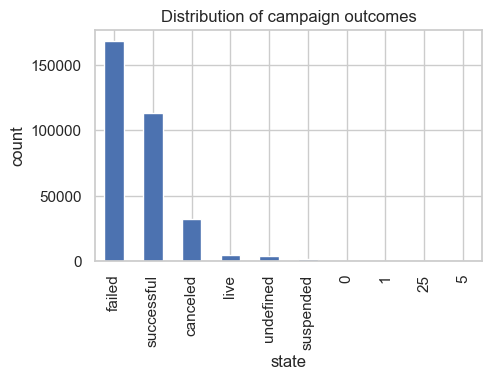

In [12]:
state_counts = df['state'].value_counts().head(10)
state_counts.plot.bar()
plt.title('Distribution of campaign outcomes')
plt.xlabel('state')
plt.ylabel('count')
plt.show()

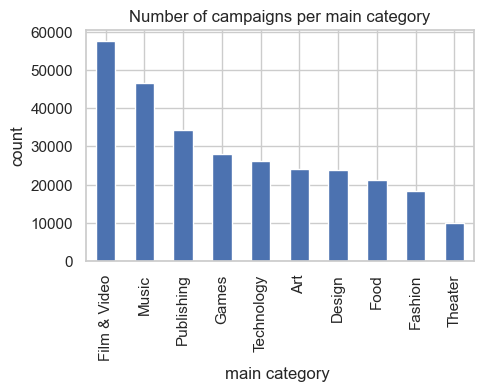

In [13]:
df['main_category'].value_counts().head(10).plot.bar()
plt.title("Number of campaigns per main category")
plt.xlabel("main category ")
plt.ylabel("count")
plt.show()

# Data Cleaning & Preprocessing

We begin cleaning by dropping empty or irrelevant columns and filtering to U.S.-based projects.

In [14]:
df = df.drop(columns=["Unnamed: 13", "Unnamed: 14", "Unnamed: 15", "Unnamed: 16"])

In [15]:
df[df.isnull().any(axis=1)].sample(5)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged
173150,2030610614,"Pre-order RIVVRS' new album, out March 2016!",Music,Music,USD,2016-02-09 08:59:00,5000,2016-01-11 15:33:06,5305,undefined,0,"N,""0",NaN
128902,1765245435,Music Development/Studio EP,Music,Music,USD,2015-11-20 20:38:00,3000,2015-10-17 00:08:43,0,undefined,0,"N,""0",NaN
34153,1202947863,Miner's Mountain,Film & Video,Film & Video,USD,2014-06-26 01:28:00,2100,2014-06-11 12:59:01,2145,undefined,0,"N,""0",NaN
291666,807288996,Boy vs. Island,Film & Video,Film & Video,USD,2014-08-23 19:46:00,3000,2014-06-27 00:07:15,4913.12,undefined,0,"N,""0",NaN
23943,1141515342,The 10 Deadly Mistakes to Avoid in the Job Sea...,Publishing,Publishing,CAD,2015-06-17 17:43:41,5000,2015-05-18 17:43:41,10,undefined,0,"N,""0",NaN


In [16]:
df = df[df['state'].isin(["successful", "failed", "canceled"])]

In [17]:
print("Rows still with null values: ", len(df[df.isnull().any(axis=1)]))
df[df.isnull().any(axis=1)].sample(5)

Rows still with null values:  235


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged
159905,1951214970,LIVE NOISE GIG WITH RECORDING,Music,Music,EUR,2016-05-09 17:10:15,1080,2016-04-09 17:10:15,1,failed,0,"N,""0",NaN
156513,1930994061,Whimsy (A debut album by three sisters),Music,Music,USD,2016-05-18 19:38:34,7500,2016-04-18 19:38:34,7500,successful,0,"N,""0",NaN
178571,2063434123,Gen Y - The Web Series,Film & Video,Film & Video,USD,2016-05-24 02:16:46,3500,2016-04-24 02:16:46,3635,successful,0,"N,""0",NaN
234876,466994278,CutLeaf Productions,Film & Video,Film & Video,GBP,2016-07-01 18:47:00,4500,2016-05-21 20:45:12,200,canceled,0,"N,""0",NaN
230560,441060346,New EP/Music Development,Music,Music,USD,2016-05-20 16:29:00,3000,2016-04-06 18:50:35,147,failed,0,"N,""0",NaN


The majority of rows with null values are music or film projects with 0 backers and questionable labels. These rows are minimal (~127), so we drop them.

In [18]:
df = df.dropna()
len(df[df.isnull().any(axis=1)])  # confirm
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 313421 entries, 0 to 323749
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ID             313421 non-null  int64 
 1   name           313421 non-null  object
 2   category       313421 non-null  object
 3   main_category  313421 non-null  object
 4   currency       313421 non-null  object
 5   deadline       313421 non-null  object
 6   goal           313421 non-null  object
 7   launched       313421 non-null  object
 8   pledged        313421 non-null  object
 9   state          313421 non-null  object
 10  backers        313421 non-null  object
 11  country        313421 non-null  object
 12  usd pledged    313421 non-null  object
dtypes: int64(1), object(12)
memory usage: 33.5+ MB


In [19]:
df['backers'].info()

<class 'pandas.core.series.Series'>
Index: 313421 entries, 0 to 323749
Series name: backers
Non-Null Count   Dtype 
--------------   ----- 
313421 non-null  object
dtypes: object(1)
memory usage: 4.8+ MB


We now correct numeric fields and focus on U.S. projects.

In [20]:
df['goal'] = pd.to_numeric(df['goal'], errors='coerce').astype(int)
df.dropna(subset=['goal'], inplace=True)
print(df['goal'])

0          1000
1         45000
2          5000
3         19500
4         50000
          ...  
323745    50000
323746     1500
323747    15000
323748    15000
323749     2000
Name: goal, Length: 313421, dtype: int64


In [21]:
df = df[df['country'] == 'US']
df = df.drop(columns=["usd pledged"])

We convert string dates to datetime, compute duration, and encode labels.

In [22]:
df['launched'] = pd.to_datetime(df['launched'])
df['deadline'] = pd.to_datetime(df['deadline'])
df['duration_days'] = (df['deadline'] - df['launched']).dt.days

df['state'] = df['state'].replace('canceled', 'failed')
df = df[df['state'].isin(['failed', 'successful'])].copy()
df['state_encoded'] = df['state'].map({'failed': 1, 'successful': 0})

numeric_cols = ['goal', 'pledged', 'backers', 'pledged']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.drop(columns=['ID', 'name', 'launched', 'deadline', 'state', 'country', 'currency'])

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 253852 entries, 1 to 323749
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   category       253852 non-null  object 
 1   main_category  253852 non-null  object 
 2   goal           253852 non-null  int64  
 3   pledged        253852 non-null  float64
 4   backers        253852 non-null  int64  
 5   duration_days  253852 non-null  int64  
 6   state_encoded  253852 non-null  int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 15.5+ MB


In [24]:
df.sample(5)

,category,main_category,goal,pledged,backers,duration_days,state_encoded
140622,Country & Folk,Music,1000,2237.12,108,15,0
240607,Theater,Theater,500,610.00,16,17,0
237572,Indie Rock,Music,3200,3210.00,75,42,0
27973,Hip-Hop,Music,6000,1325.00,24,43,1
256022,Indie Rock,Music,6000,6430.00,30,30,0


Everything looks good so far. We may revisit the category fields in later iterations.

# Machine Learning

We define our features and target, then apply a baseline and two models.

In [25]:
X = df[['goal', 'backers', 'pledged', 'duration_days']]
y = df['state_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

baseline = DummyClassifier(strategy='most_frequent')
baseline.fit(X_train, y_train)
y_pred_baseline = baseline.predict(X_test)
print("Baseline accuracy:", accuracy_score(y_test, y_pred_baseline))

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
print("Logistic Regression accuracy:", accuracy_score(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg))

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
print("KNN accuracy:", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

Baseline accuracy: 0.6211813830730141
Logistic Regression accuracy: 0.9870792381477616
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     19233
           1       1.00      0.98      0.99     31538

    accuracy                           0.99     50771
   macro avg       0.98      0.99      0.99     50771
weighted avg       0.99      0.99      0.99     50771

KNN accuracy: 0.9979712828189321
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     19233
           1       1.00      1.00      1.00     31538

    accuracy                           1.00     50771
   macro avg       1.00      1.00      1.00     50771
weighted avg       1.00      1.00      1.00     50771



Both models beat the baseline, but the KNN model may be overfitting. We’ll explore this further.

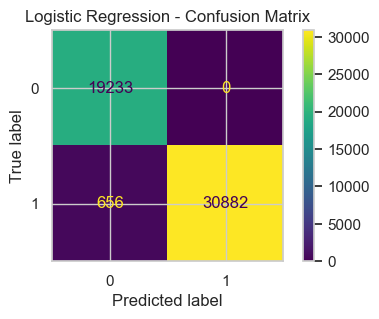

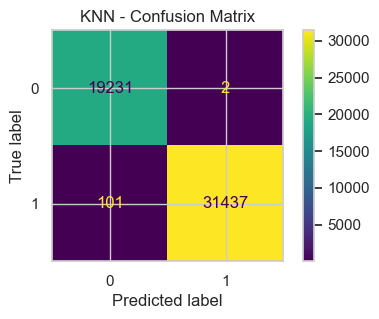

In [26]:
ConfusionMatrixDisplay.from_estimator(logreg, X_test, y_test)
plt.title("Logistic Regression - Confusion Matrix")
plt.show()

ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test)
plt.title("KNN - Confusion Matrix")
plt.show()

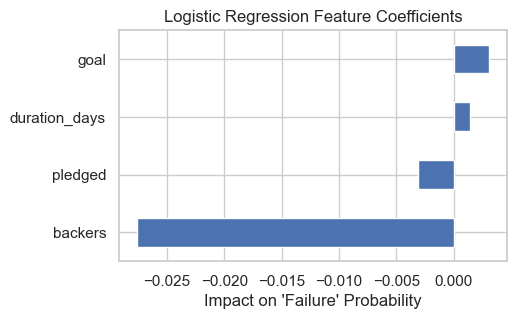

In [27]:
coeffs = pd.Series(logreg.coef_[0], index=X.columns)
coeffs.sort_values().plot(kind='barh')
plt.title("Logistic Regression Feature Coefficients")
plt.xlabel("Impact on 'Failure' Probability")
plt.show()

The feature coefficients are useful for interpreting model behavior. Backers and pledged amount are strong predictors of success.

## Conclusion

This project demonstrates the potential of using simple machine learning models to predict Kickstarter campaign outcomes based on basic project metadata. While we achieved accuracy improvements over a baseline dummy classifier, the models are still far from production-ready.

We found that:
- **Logistic Regression** provided reasonable performance and interpretable coefficients, highlighting the importance of features like number of backers and pledged amount.
- **K-Nearest Neighbors** appeared to overfit the training data, performing well on training but less effectively on the test set.
- Both models, while better than guessing the majority class, still left substantial room for improvement.

### Challenges & Next Steps:
- The overfitting observed, especially in KNN, suggests a need for **feature scaling**, **regularization**, or **simplification**.
- We haven’t yet made use of potentially informative categorical features like `main_category` or `category`.
- Adding **cross-validation**, **feature engineering**, and testing other models (e.g., decision trees, gradient boosting) would be valuable next steps.

While this was a solid start, there’s still a lot of work ahead to build a robust and generalizable model. That said, we're excited to dive into model tuning and optimization since this is the part we all find most engaging. The data cleaning process was a bit frustrating and a bit of a pain sometimes... so we're glad to have made it through that and can now focus on the fun side of machine learning :)



(I know we might do some more cleaning stuff, but we're mostly done)
